SUMMARY
================================================================================


These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.



INFORMATION ABOUT THE GROUPLENS RESEARCH PROJECT
================================================================================

The GroupLens Research Project is a research group in the Department of 
Computer Science and Engineering at the University of Minnesota. Members of 
the GroupLens Research Project are involved in many research projects related 
to the fields of information filtering, collaborative filtering, and 
recommender systems. The project is lead by professors John Riedl and Joseph 
Konstan. The project began to explore automated collaborative filtering in 
1992, but is most well known for its world wide trial of an automated 
collaborative filtering system for Usenet news in 1996. Since then the project 
has expanded its scope to research overall information filtering solutions, 
integrating in content-based methods as well as improving current collaborative 
filtering technology.

Further information on the GroupLens Research project, including research 
publications, can be found at the following web site:
        
        http://www.grouplens.org/

GroupLens Research currently operates a movie recommender based on 
collaborative filtering:

        http://www.movielens.org/

RATINGS FILE DESCRIPTION
================================================================================

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

USERS FILE DESCRIPTION
================================================================================

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

MOVIES FILE DESCRIPTION
================================================================================

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist


### Preliminaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Reading Data

In [2]:
ratings_cols = ['UserID','MovieID','Rating','Timestamp']
ratings = pd.read_csv('ratings.dat', sep='::', encoding='latin-1',names=ratings_cols)
print ('Shape of ratings:{}'.format(ratings.shape))
ratings = ratings.drop('Timestamp',axis=1)
ratings.head()

Shape of ratings:(1000209, 4)


,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [3]:
users_cols = ['UserID','Gender','Age','Occupation','Zip_code']
users = pd.read_csv('users.dat', sep='::', encoding='latin-1',names=users_cols)
print ('Shape of users:{}'.format(users.shape))
users.head()

Shape of users:(6040, 5)


,UserID,Gender,Age,Occupation,Zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
users['Gender'].replace({'F':0,'M':1},inplace=True)
users['Age'].replace({1: "Under 18",18: "18-24",25: "25-34",35: "35-44",45: "45-49",50: "50-55",56: "56+"},inplace=True)
users['Occupation'].replace({0: "other or not specified",1: "academic/educator",2: "artist",\
                             3: "clerical/admin",4: "college/grad student",5: "customer service",\
                             6: "doctor/health care",7: "executive/managerial",8: "farmer",\
                             9: "homemaker",10: "K-12 student",11: "lawyer",12: "programmer",\
                             13: "retired",14: "sales/marketing",15: "scientist",16: "self-employed",\
                             17: "technician/engineer",18: "tradesman/craftsman",19: "unemployed",20: "writer"},inplace=True)
users.head()

,UserID,Gender,Age,Occupation,Zip_code
0,1,0,Under 18,K-12 student,48067
1,2,1,56+,self-employed,70072
2,3,1,25-34,scientist,55117
3,4,1,45-49,executive/managerial,02460
4,5,1,25-34,writer,55455


In [5]:
movies_cols = ['MovieID','Title','Genres']
movies = pd.read_csv('movies.dat',sep='::',names=movies_cols)
print ('Shape of movies:{}'.format(movies.shape))
movies.head()

Shape of movies:(3883, 3)


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### EDA

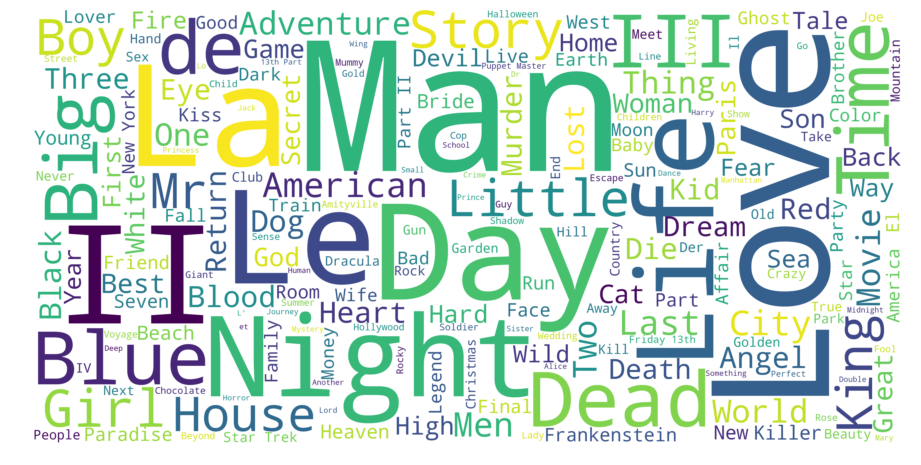

In [6]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['Title'] = movies['Title'].fillna("").astype('str')
title_corpus = ' '.join(movies['Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud,interpolation='bilinear')
plt.axis('off');

- Movie names with words like Day, Love, Life, Night, Man, Dead etc are among the most commonly occuring words.

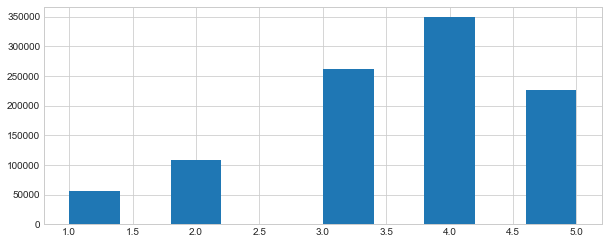

In [7]:
plt.figure(figsize=(10,4))
ratings['Rating'].hist(bins=10);

In [8]:
df = pd.merge(ratings,movies,on='MovieID')
df.head()

,UserID,MovieID,Rating,Title,Genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama


In [9]:
df.groupby('Title')['Rating'].mean().sort_values(ascending=False).head()

Title
Gate of Heavenly Peace, The (1995)    5.0
Lured (1947)                          5.0
Ulysses (Ulisse) (1954)               5.0
Smashing Time (1967)                  5.0
Follow the Bitch (1998)               5.0
Name: Rating, dtype: float64

In [10]:
df.groupby('Title')['Rating'].count().sort_values(ascending=False).head()

Title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Name: Rating, dtype: int64

In [11]:
grading = pd.DataFrame(df.groupby('Title')['Rating'].mean())
grading.head()

,Rating
Title,
"$1,000,000 Duck (1971)",3.027027
'Night Mother (1986),3.371429
'Til There Was You (1997),2.692308
"'burbs, The (1989)",2.910891
...And Justice for All (1979),3.713568


In [12]:
grading['num of ratings'] = pd.DataFrame(df.groupby('Title')['Rating'].count())
grading.head()

,Rating,num of ratings
Title,,
"$1,000,000 Duck (1971)",3.027027,37
'Night Mother (1986),3.371429,70
'Til There Was You (1997),2.692308,52
"'burbs, The (1989)",2.910891,303
...And Justice for All (1979),3.713568,199


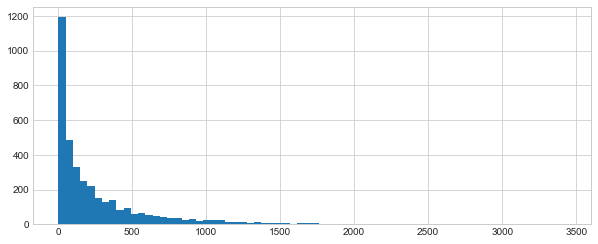

In [13]:
plt.figure(figsize=(10,4))
grading['num of ratings'].hist(bins=70);

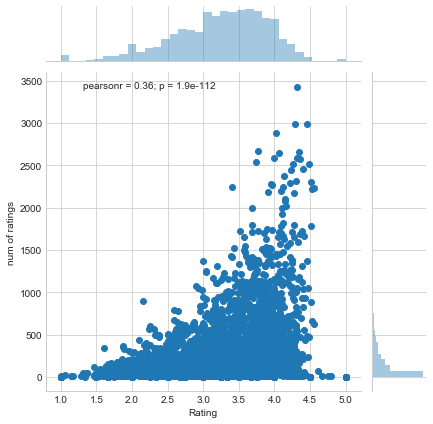

In [14]:
sns.jointplot(x='Rating',y='num of ratings',data=grading);

### Content Based filtering

In [15]:
# Break up the big genre string into a string array
movies['Genres'] = movies['Genres'].str.split('|')
# Convert genres to string value
movies['Genres'] = movies['Genres'].fillna("").astype('str')

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['Genres'])
tfidf_matrix.shape

(3883, 303)

In [17]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [18]:
# Build a 1-dimensional array with movie titles
titles = movies['Title']
indices = pd.Series(movies.index, index=movies['Title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [19]:
genre_recommendations('Jumanji (1995)')

55          Kids of the Round Table (1995)
59      Indian in the Cupboard, The (1995)
124      NeverEnding Story III, The (1994)
996        Escape to Witch Mountain (1975)
1898                      Labyrinth (1986)
Name: Title, dtype: object

In [20]:
genre_recommendations("Star Trek: The Wrath of Khan (1982)")

313                          Stargate (1994)
325            Star Trek: Generations (1994)
476                     Jurassic Park (1993)
1335         Star Trek: First Contact (1996)
1350    Star Trek: The Motion Picture (1979)
Name: Title, dtype: object

### Collaborative Filtering

In [21]:
# Fill NaN values in user_id and movie_id column with 0
ratings['UserID'] = ratings['UserID'].fillna(0)
ratings['MovieID'] = ratings['MovieID'].fillna(0)

# Replace NaN values in rating column with average of all values
ratings['Rating'] = ratings['Rating'].fillna(ratings['Rating'].mean())

In [22]:
# Randomly sample 5% of the ratings dataset
sample_subset = ratings.sample(frac=0.02)
# Check the sample info
print(sample_subset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 925781 to 25688
Data columns (total 3 columns):
UserID     20004 non-null int64
MovieID    20004 non-null int64
Rating     20004 non-null int64
dtypes: int64(3)
memory usage: 625.1 KB
None


In [23]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(sample_subset, test_size=0.2)

C:\Users\Admin\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.as_matrix(columns = ['UserID', 'MovieID', 'Rating'])
test_data_matrix = test_data.as_matrix(columns = ['UserID', 'MovieID', 'Rating'])

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(16003L, 3L)
(4001L, 3L)


In [26]:
from sklearn.metrics.pairwise import pairwise_distances
# User Similarity Matrix
user_similarity = 1 - pairwise_distances(train_data, metric='cosine')
user_similarity[np.isnan(user_similarity)] = 0

In [27]:
# Item Similarity Matrix
item_similarity = 1 - pairwise_distances(train_data_matrix.T, metric='cosine')
item_similarity[np.isnan(item_similarity)] = 0

In [28]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [29]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [30]:
item_prediction

array([[2768.52070261, 2670.86677059, 2494.94409783],
       [ 773.15778099, 1039.05321108,  818.72474395],
       [1676.54959733, 1826.10630662, 1597.78076906],
       ...,
       [ 932.21806843,  703.91449565,  759.31064515],
       [ 980.70925759, 1151.90326971,  969.47368532],
       [2264.20690296, 1983.07318932, 1956.79057361]])

In [31]:
user_prediction

array([[4103.60166794, 2885.2132994 , 1015.18503266],
       [1745.0812232 , 1591.39275333, -671.47397653],
       [2969.42196976, 2089.18656345,   94.39146679],
       ...,
       [2536.1026888 ,  770.51173869, -897.61442749],
       [2167.90415041, 1525.89398481, -556.79813522],
       [3647.05275102, 2193.62730022,  410.31994876]])

### Evaluation

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [33]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 847.299681701
Item-based CF RMSE: 1462.40810708


In [34]:
# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1374.01652881
Item-based CF RMSE: 1794.38907398


***